In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import warnings
import seaborn as sns

In [35]:
svm_data = {'x1': [0.3858, 0.4871, 0.9218, 0.7328, 0.1763, 0.4057, 0.9355, 0.2146],
            'x2': [0.4687, 0.611, 0.4103, 0.8936, 0.0579, 0.3529, 0.8132, 0.0099],
            'label': [1, -1, -1, -1, 1, 1, -1, 1]}
#'label': ["P:1", "N:-1", "N:-1", "N:-1", "P:1", "P:1", "N:-1", "P:1"]}
svm_data = pd.DataFrame(svm_data)

In [128]:
svm_data

,x1,x2,label
0,0.3858,0.4687,1
1,0.4871,0.6110,-1
2,0.9218,0.4103,-1
3,0.7328,0.8936,-1
4,0.1763,0.0579,1
5,0.4057,0.3529,1
6,0.9355,0.8132,-1
7,0.2146,0.0099,1


In [3]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [1, 1], np.random.randn(20, 2),np.random.randn(10, 2) + [1, 0],np.random.randn(10, 2) + [0, 1]]  #.r_  连接
#对于随机样本N（\ mu，\ sigma ^ 2），请使用：sigma * np.random.randn(...) + mu
svm_data = pd.DataFrame(X)

In [4]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [1, 1], np.random.randn(20, 2),np.random.randn(20, 2) + [1, 0],np.random.randn(20, 2) + [0, 1]]  #.r_  连接
#对于随机样本N（\ mu，\ sigma ^ 2），请使用：sigma * np.random.randn(...) + mu
svm_data = pd.DataFrame(X,columns=['x1','x2'])
label =pd.DataFrame( np.array( [1] * 40 + [-1] * 40).reshape(80,1),columns=['label'])
svm_data=pd.concat([svm_data,label],axis=1)

In [25]:
def linear_kernel(x, y,sig=1):
    return np.dot(x, y.T)*sig
    # 线性核函数

def gaussian_kernel(x1, x2, sig=2):
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sig ** 2)))
    # 高斯核函数

def polynomial_kernel(x, y, sig=3):
    return (1 + np.dot(x, y.T)) ** sig
    # 多项式核函数

In [57]:
def SVM(svm_data, kernel,sig=1, C=100, lowx=0, highx=5, lowy=0, highy=5, split_num=50):
    from cvxopt import matrix, solvers
   # C = 100  # 惩罚因子
    sum_alpha = 0  # 拉格朗日承子
    P = np.mat(svm_data.values)  # 数据转化为矩阵[data，label]
    Data_num = P.shape[0]  # 数据量
    Features_num = P.shape[1]-1  # 特征数量
    # w = [0]*Features_num  # 法向量
    b_w = [0]*Data_num  # 截距
    svm_b = 0  # 平均截距

    P_matrix = np.mat(np.zeros((Data_num, Data_num)))
    for i in range(Data_num):
        for j in range(Data_num):
            P_matrix[i, j] = kernel(P[i, :-1], P[j, :-1],sig)*P[i, -1:]*P[j, -1:]
            # P_matrix[i,j]=P[i,:-1]*P[j,:-1].T*P[i,-1:]*P[j,-1:]
    P_matrix = matrix(P_matrix.T)
    Q_matrix = matrix(-1*np.ones((Data_num, 1)))
    # 计算二次规划P，Q矩阵

    A_matrix = np.mat(np.zeros((1, Data_num)))
    for i in range(Data_num):
        A_matrix[0, i] = P[i, -1:]
    A_matrix = matrix(A_matrix.T, (1, Data_num))
    b = matrix([0.0])
    # 计算二次规划A，b矩阵（等式约束）

    G_matrix = np.vstack(((-1*np.eye(Data_num), np.eye(Data_num))))
    h = np.vstack(((np.zeros((Data_num, 1))), C*np.ones((Data_num, 1))))
    G_matrix = matrix(G_matrix)
    h = matrix(h.T, (2*Data_num, 1))
    # 计算二次规划G，h矩阵（不等式约束）

    result = solvers.qp(P_matrix, Q_matrix, G_matrix, h, A_matrix, b)
    # 求解二次规划问题
    # cvxopt.matrix与numpy.matrix的排列顺序不同，其中cvxopt.matrix是列优先，numpy.matrix是行优先

    for i in range(Data_num):
        for j in range(Data_num):
            #b_w[i] = b_w[i]+w[j]*P[i, j]
            b_w[i] = b_w[i]+result['x'][j] * \
                P[j, -1]*kernel(P[i, :-1], P[j, :-1],sig)

    for i in range(Data_num):
        b_w[i] = P[i, -1]-b_w[i]
    # 计算截距，之后对多个截距取平均

    for i in range(Data_num):
        svm_b = svm_b+b_w[i]*result['x'][i]
        sum_alpha = sum_alpha+result['x'][i]
    svm_b = svm_b/sum_alpha
    # 支持向量拉格朗日乘子为0，但cvxopt包无法精确到0，我按照求解的大小赋权，否则截距不准确
    # 当然也可以设定一个阈值，当拉格朗日乘子小于该值就认为是0

    x1, x2 = np.meshgrid(np.linspace(lowx, highx, split_num),
                         np.linspace(lowy, highy, split_num))
    x = np.array([[x1, x2] for x1, x2, in zip(np.ravel(x1), np.ravel(x2))])
    y_predict = np.zeros(len(x))
    for i in range(len(x)):
        s = 0
        for j in range(Data_num):
            s += result['x'][j] * P[j, -1] * kernel(x[i], P[j, :-1],sig)
        y_predict[i] = s
    z = y_predict + svm_b
    z = z.reshape(x1.shape)

    # YlGnBu  PuBu plt.get_cmap('PuBu')
    plt.contourf(x1, x2, z, alpha=0.75, cmap=plt.cm.RdBu)
    plt.contour(x1, x2, z, [0.0], colors='blue', linewidths=1, origin='lower')
    plt.contour(x1, x2, z + 1, [0.0], colors='green',
                linewidths=1, origin='lower')
    plt.contour(x1, x2, z - 1, [0.0], colors='red',
                linewidths=1, origin='lower')
    plt.scatter(P[:, 0].tolist(), P[:, 1].tolist(), c=P[:, -1].tolist(), s=100, alpha=0.9,
                cmap=plt.cm.bone, edgecolors='black')
    plt.axis('off')
    title = "C=%s    sig=%s" % (C,sig)
    plt.title(title)

     pcost       dcost       gap    pres   dres
 0: -4.0309e+02 -1.5987e+03  1e+03  3e-14  3e-14
 1: -6.1430e+02 -8.0493e+02  2e+02  3e-14  1e-14
 2: -7.9468e+02 -7.9872e+02  4e+00  2e-16  2e-14
 3: -7.9650e+02 -7.9654e+02  4e-02  2e-16  3e-14
 4: -7.9651e+02 -7.9651e+02  4e-04  2e-16  2e-14
Optimal solution found.


/usr/Python-3.6.5/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


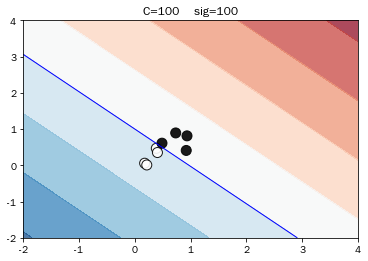

In [54]:
SVM(svm_data,gaussian_kernel,sig=100,C=100,lowx=-2,highx=4,lowy=-2,highy=4) #linear_kernel   polynomial_kernel   gaussian_kernel

In [ ]:
Cf=plt.contourf(x1, x2, z,alpha=0.75, cmap=plt.cm.bone)
plt.scatter(P[:, 0].tolist(), P[:, 1].tolist(), c=P[:, -1].tolist(), s=100, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')
plt.clabel(Cf, inline=True, fontsize=10)

## SVM

In [81]:
def SVM(svm_data, kernel, sig=1, C=100):
    from cvxopt import matrix, solvers
    # C = 100  # 惩罚因子
    sum_alpha = 0  # 拉格朗日承子
    P = np.mat(svm_data.values)  # 数据转化为矩阵[data，label]
    Data_num = P.shape[0]  # 数据量
    Features_num = P.shape[1]-1  # 特征数量
    # w = [0]*Features_num  # 法向量
    b_w = [0]*Data_num  # 截距
    svm_b = 0  # 平均截距

    P_matrix = np.mat(np.zeros((Data_num, Data_num)))
    for i in range(Data_num):
        for j in range(Data_num):
            P_matrix[i, j] = kernel(
                P[i, :-1], P[j, :-1], sig)*P[i, -1:]*P[j, -1:]
            # P_matrix[i,j]=P[i,:-1]*P[j,:-1].T*P[i,-1:]*P[j,-1:]
    P_matrix = matrix(P_matrix.T)
    Q_matrix = matrix(-1*np.ones((Data_num, 1)))
    # 计算二次规划P，Q矩阵

    A_matrix = np.mat(np.zeros((1, Data_num)))
    for i in range(Data_num):
        A_matrix[0, i] = P[i, -1:]
    A_matrix = matrix(A_matrix.T, (1, Data_num))
    b = matrix([0.0])
    # 计算二次规划A，b矩阵（等式约束）

    G_matrix = np.vstack(((-1*np.eye(Data_num), np.eye(Data_num))))
    h = np.vstack(((np.zeros((Data_num, 1))), C*np.ones((Data_num, 1))))
    G_matrix = matrix(G_matrix)
    h = matrix(h.T, (2*Data_num, 1))
    # 计算二次规划G，h矩阵（不等式约束）

    result = solvers.qp(P_matrix, Q_matrix, G_matrix, h, A_matrix, b)
    # 求解二次规划问题
    # cvxopt.matrix与numpy.matrix的排列顺序不同，其中cvxopt.matrix是列优先，numpy.matrix是行优先

    for i in range(Data_num):
        for j in range(Data_num):
            #b_w[i] = b_w[i]+w[j]*P[i, j]
            b_w[i] = b_w[i]+result['x'][j] * \
                P[j, -1]*kernel(P[i, :-1], P[j, :-1], sig)

    for i in range(Data_num):
        b_w[i] = P[i, -1]-b_w[i]
    # 计算截距，之后对多个截距取平均

    for i in range(Data_num):
        svm_b = svm_b+b_w[i]*result['x'][i]
        sum_alpha = sum_alpha+result['x'][i]
    svm_b = svm_b/sum_alpha
    # 支持向量拉格朗日乘子为0，但cvxopt包无法精确到0，我按照求解的大小赋权，否则截距不准确
    # 当然也可以设定一个阈值，当拉格朗日乘子小于该值就认为是0
    return P, result, svm_b, sig, kernel,Data_num,C

## 绘图

In [113]:
def plot_svm(ax,P, result, svm_b, sig, kernel, Data_num,C,lowx=0, highx=5, lowy=0, highy=5, split_num=50): 
    x1, x2 = np.meshgrid(np.linspace(lowx, highx, split_num),
                         np.linspace(lowy, highy, split_num))
    x = np.array([[x1, x2] for x1, x2, in zip(np.ravel(x1), np.ravel(x2))])
    y_predict = np.zeros(len(x))
    for i in range(len(x)):
        s = 0
        for j in range(Data_num):
            s += result['x'][j] * P[j, -1] * kernel(x[i], P[j, :-1],sig)
        y_predict[i] = s
    z = y_predict + svm_b
    z = z.reshape(x1.shape)

    # YlGnBu  PuBu plt.get_cmap('PuBu')  plt.cm.RdBu
    ax.contourf(x1, x2, z, alpha=0.75, cmap=plt.cm.Spectral)
    ax.contour(x1, x2, z, [0.0], colors='blue', linewidths=1, origin='lower')
    ax.contour(x1, x2, z + 1, [0.0], colors='green',
                linewidths=1, origin='lower')
    ax.contour(x1, x2, z - 1, [0.0], colors='red',
                linewidths=1, origin='lower')
    ax.scatter(P[:, 0].tolist(), P[:, 1].tolist(), c=P[:, -1].tolist(), s=15, alpha=0.9,
                cmap=plt.get_cmap('pink'), edgecolors='k')
    ax.axis('off')
    title = "C=%s    sig=%s" % (C,sig)
    ax.set_title(title)

In [17]:
from sklearn.datasets import make_moons, make_circles, make_classification
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

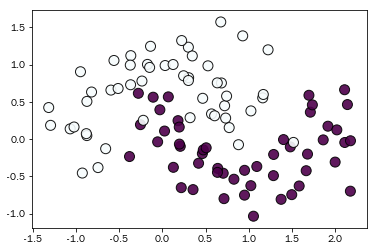

In [120]:
plt.scatter(datasets[0][0][:, 0].tolist(), datasets[0][0][:, 1].tolist(), c=datasets[0][1].tolist(), s=100, alpha=0.9,
                cmap=plt.get_cmap('BuPu'), edgecolors='black')

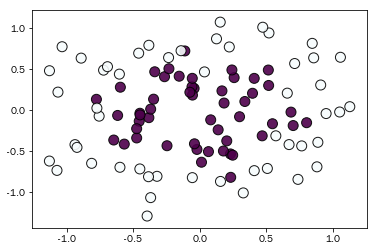

In [121]:
plt.scatter(datasets[1][0][:, 0].tolist(), datasets[1][0][:, 1].tolist(), c=datasets[1][1].tolist(), s=100, alpha=0.9,
                cmap=plt.get_cmap('BuPu'), edgecolors='black')

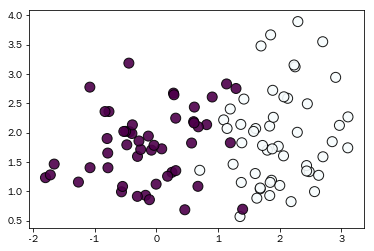

In [122]:
plt.scatter(datasets[2][0][:, 0].tolist(), datasets[2][0][:, 1].tolist(), c=datasets[2][1].tolist(), s=100, alpha=0.9,
                cmap=plt.get_cmap('BuPu'), edgecolors='black')

In [123]:
linearly_separable_data=pd.concat([pd.DataFrame(datasets[2][0][:, 0],columns=['x1']),pd.DataFrame(datasets[2][0][:, 1],columns=['x2']),pd.DataFrame(datasets[2][1],columns=['label'])],axis=1)
circles_data=pd.concat([pd.DataFrame(datasets[1][0][:, 0],columns=['x1']),pd.DataFrame(datasets[1][0][:, 1],columns=['x2']),pd.DataFrame(datasets[1][1],columns=['label'])],axis=1)
moons_data=pd.concat([pd.DataFrame(datasets[0][0][:, 0],columns=['x1']),pd.DataFrame(datasets[0][0][:, 1],columns=['x2']),pd.DataFrame(datasets[0][1],columns=['label'])],axis=1)

In [19]:
linearly_separable_data['label'][linearly_separable_data['label']==0]=-1
circles_data['label'][circles_data['label']==0]=-1
moons_data['label'][moons_data['label']==0]=-1

/usr/Python-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/Python-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/Python-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


     pcost       dcost       gap    pres   dres
 0: -4.8063e+01 -4.5858e+03  6e+03  2e-01  8e-15
 1: -1.6692e+02 -7.4877e+02  6e+02  1e-02  8e-15
 2: -2.7525e+02 -4.5526e+02  2e+02  2e-03  8e-15
 3: -3.1558e+02 -3.9787e+02  8e+01  6e-04  9e-15
 4: -3.2783e+02 -3.8340e+02  6e+01  4e-04  9e-15
 5: -3.4031e+02 -3.6034e+02  2e+01  8e-05  1e-14
 6: -3.4520e+02 -3.5231e+02  7e+00  2e-05  9e-15
 7: -3.4711e+02 -3.4968e+02  3e+00  6e-06  8e-15
 8: -3.4818e+02 -3.4830e+02  1e-01  2e-07  1e-14
 9: -3.4824e+02 -3.4824e+02  2e-03  3e-09  1e-14
10: -3.4824e+02 -3.4824e+02  2e-05  3e-11  1e-14
Optimal solution found.


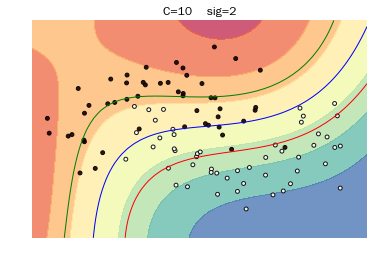

In [114]:
ax = plt.subplot(1,1, 1)
P, result, svm_b, sig, kernel,Data_num,C = SVM(
    moons_data, gaussian_kernel, sig=2, C=10)
plot_svm(ax,P, result, svm_b, sig, kernel,Data_num,C,lowx=-1.5, highx=2.5, lowy=-1.5, highy=2, split_num=50)  #polynomial_kernel  gaussian_kernel  linear_kernel

In [ ]:
P, result, svm_b, sig, kernel,Data_num,C = SVM(
    moons_data, gaussian_kernel, sig=2, C=10)
plot_svm(P, result, svm_b, sig, kernel,Data_num, C,lowx=-1.5, highx=2.5, lowy=-1.5, highy=2, split_num=50)

     pcost       dcost       gap    pres   dres
 0: -5.0000e+01 -1.5000e+02  4e+02  1e+00  1e-16
 1: -4.1599e+01 -8.0870e+01  4e+01  1e-02  3e-16
 2: -4.9111e+01 -5.0728e+01  2e+00  6e-04  4e-16
 3: -4.9991e+01 -5.0007e+01  2e-02  6e-06  4e-16
 4: -5.0000e+01 -5.0000e+01  2e-04  6e-08  3e-16
 5: -5.0000e+01 -5.0000e+01  2e-06  6e-10  5e-16
Optimal solution found.


/usr/Python-3.6.5/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


     pcost       dcost       gap    pres   dres
 0: -2.7500e+02 -3.7500e+03  5e+03  1e-01  1e-15
 1: -3.0654e+02 -5.5694e+02  3e+02  7e-03  1e-15
 2: -4.9813e+02 -5.1720e+02  2e+01  3e-04  1e-15
 3: -4.9998e+02 -5.0017e+02  2e-01  3e-06  1e-15
 4: -5.0000e+02 -5.0000e+02  2e-03  3e-08  2e-15
 5: -5.0000e+02 -5.0000e+02  2e-05  3e-10  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.5250e+03 -2.6250e+05  3e+05  1e-02  1e-14
 1: -2.5721e+03 -7.6211e+03  5e+03  3e-04  1e-14
 2: -4.5007e+03 -5.0732e+03  6e+02  2e-05  1e-14
 3: -4.9950e+03 -5.0013e+03  6e+00  3e-07  3e-14
 4: -5.0000e+03 -5.0000e+03  6e-02  3e-09  3e-14
 5: -5.0000e+03 -5.0000e+03  6e-04  3e-11  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.5025e+04 -2.5125e+07  3e+07  1e-03  2e-13
 1: -2.5074e+04 -3.0080e+05  3e+05  2e-05  2e-13
 2: -2.9213e+04 -5.2585e+04  2e+04  1e-06  1e-13
 3: -4.9792e+04 -5.1887e+04  2e+03  6e-08  1e-12
 4: -4.9998e+04 -5.0019e

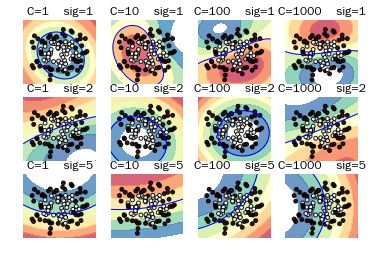

In [127]:
i=1
for sig in [1,2,5]:
    for C in [1,10,100,1000]:
        ax = plt.subplot(3,4, i)
        P, result, svm_b, sig, kernel,Data_num,C = SVM(
        circles_data, gaussian_kernel, sig=sig, C=C)
        plot_svm(ax,P, result, svm_b, sig, kernel,Data_num, C,lowx=-1.5, highx=1.5, lowy=-1.5, highy=1.5, split_num=50)
        i=i+1

In [ ]:
i=1
for sig in [1,2,5]:
    for C in [1,10,100,1000]:
        ax = plt.subplot(3,4, i)
        P, result, svm_b, sig, kernel,Data_num,C = SVM(
        moons_data, gaussian_kernel, sig=sig, C=C)
        plot_svm(ax,P, result, svm_b, sig, kernel,Data_num, C,lowx=-1.5, highx=2.5, lowy=-1.5, highy=2, split_num=50)
        i=i+1